In [74]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import html
from bs4 import BeautifulSoup
import requests
from requests.exceptions import Timeout
import pandas as pd
import numpy as np
# import cupy as cp
from helium import * # if helium gives you chrome webdriver error, download latest chrome driver, and move it to here: .conda\Lib\site-packages\helium\_impl\webdrivers\windows ... source: https://github.com/mherrmann/selenium-python-helium/issues/55
import cv2
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ChromeOptions

from pprint import pprint
import regex as re
from multiprocessing import Process
import multiprocessing
import pickle
import os
import itertools
import asyncio
import base64
from sys import getsizeof
import shutil
import json
import time
from datetime import datetime

import IPython
import matplotlib.pyplot  as plt
from PIL import Image, ImageFile
from pathlib import Path
import imagesize
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as mplPath

import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output

import lzma
from tqdm.notebook import tqdm
from collections import Counter
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from functools import partial

from tensorflow import keras
from tensorflow.python.keras import optimizers, layers, models
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
from tf_f1score import F1Score
from sklearn.metrics import classification_report 

import imageio

import download_imgs # used in getAsyncImgFunctions()

In [2]:
# pio.templates.default = "none"
pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=False)
cf.go_offline()

In [3]:
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    return content

def pklForceLoad(path, dtype = 'dict'):
    try:
        content = pklLoad(path)
        return content
    except Exception as e:
        if dtype == 'list':
            pklSave([], path)
            return []
        else:
            pklSave({}, path)
            return {}

# more about naming standards for path components here: https://stackoverflow.com/questions/2235173/what-is-the-naming-standard-for-path-components
def joinPaths(baseDirectory, relativePath):
    return os.path.normpath(os.path.join(baseDirectory, relativePath))

def changeSep(path, newSep, oldSep=os.path.sep): 
    # source: https://stackoverflow.com/questions/18707338/print-raw-string-from-variable-not-getting-the-answers#:~:text=To%20turn%20a%20variable%20to%20raw%20str%2C%20just%20use
    return os.path.normpath(rf"{path}").replace(os.path.sep, newSep) # source: https://mail.python.org/pipermail/tutor/2011-July/084788.html

In [4]:
dataDir = 'dataset/'
dataReDir = 'dataset_related/'
dataSplit = 'dataset_split/'

# Seeing current dataset's Metadata (Sync vs Async vs Parallel)

In [11]:
# draft: running synchronously

ImageFile.LOAD_TRUNCATED_IMAGES = True # allow truncated images to be read by PIL, which is used by imageio library
trainPath = joinPaths(dataSplit, 'train')
rows=[]
for className in os.listdir(trainPath):
    classPath = joinPaths(trainPath, className)
    for imgName in tqdm(os.listdir(classPath)):
        img = imageio.imread(joinPaths(classPath, imgName))
        imgMeta = dict(img.meta)
        imgMeta['width'] = img.shape[0]
        imgMeta['height'] = img.shape[1]
        imgMeta['className'] = className
        imgMeta['imgName'] = imgName
        rows.append(imgMeta)
metaDf = pd.DataFrame(rows)
metaDf.insert(0, 'className', metaDf.pop('className'))
metaDf.insert(1, 'imgName', metaDf.pop('imgName'))
metaDf.insert(2, 'width', metaDf.pop('width'))
metaDf.insert(3, 'height', metaDf.pop('height'))

  0%|          | 0/32783 [00:00<?, ?it/s]

C:\Users\ashra\AppData\Local\Temp\ipykernel_23300\3068520126.py:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



  0%|          | 0/21711 [00:00<?, ?it/s]

  0%|          | 0/9867 [00:00<?, ?it/s]

  0%|          | 0/3285 [00:00<?, ?it/s]

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/11324 [00:00<?, ?it/s]

  0%|          | 0/11889 [00:00<?, ?it/s]

In [9]:
# draft: running asynchronously
# source: https://stackoverflow.com/questions/47518874/how-do-i-run-python-asyncio-code-in-a-jupyter-notebook#:~:text=Add%20a%20comment-,20,My%20aha%20moment%20with%20Asyncio%20in%20Jupyter%20looks%20like%20this%3A,-import%20time%2Casyncio
# and this for starmap() and returning results from await asyncio.gather(): https://stackoverflow.com/questions/44745519/python-asyncio-pass-list-of-argument-to-function-defined-with#:~:text=You%20also%20can%20use%20the%20itertools.starmap%20for%20this%20task%3A

ImageFile.LOAD_TRUNCATED_IMAGES = True # allow truncated images to be read by PIL, which is used by imageio library
curImg = 0
async def getImgMeta(path, className, imgName):
    img = imageio.imread(path)
    imgMeta = dict(img.meta)
    imgMeta['width'] = img.shape[0]
    imgMeta['height'] = img.shape[1]
    imgMeta['className'] = className # os.path.basename(os.path.dirname(path))
    imgMeta['imgName'] = imgName
    global curImg
    if (curImg % 10000 == 0):
        print(curImg)
    curImg += 1
    return imgMeta

async def loadImgsMetaInParallel():
    trainPath = joinPaths(dataSplit, 'train')
    paths = []
    for className in os.listdir(trainPath):
        classPath = joinPaths(trainPath, className)
        for imgName in os.listdir(classPath):
            paths.append((joinPaths(classPath, imgName), className, imgName))

    tasks = itertools.starmap(getImgMeta, paths) # each element in paths list is an argument passed to getImgMeta function
    imgsMeta = await asyncio.gather(*tasks)
    return imgsMeta

# imgsMeta = await loadImgsMetaInParallel()

C:\Users\ashra\AppData\Local\Temp\ipykernel_21592\1662349436.py:6: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [9]:
# running parallely
# source: https://jupyter-tutorial.readthedocs.io/en/stable/performance/multiprocessing.html
import imageio
from PIL import ImageFile
from multiprocessing.pool import ThreadPool as Pool
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True # allow truncated images to be read by PIL, which is used by imageio library
curImg = 0

def getImgMetaSynced(path, className, imgName):
    img = imageio.imread(path)
    imgMeta = dict(img.meta)
    imgMeta['width'] = img.shape[0]
    imgMeta['height'] = img.shape[1]
    imgMeta['className'] = className # os.path.basename(os.path.dirname(path))
    imgMeta['imgName'] = imgName
    global curImg
    if (curImg % 10000 == 0):
        print(curImg)
    curImg += 1
    return imgMeta

def runParallel(path, noClasses=False):
    pool = Pool(8)
    paths = []
    for className in os.listdir(path):
        classPath = joinPaths(path, className)
        if noClasses: # then "className" is actually imgName
            paths.append((classPath, path, className))
            continue
        for imgName in os.listdir(classPath):
            paths.append((joinPaths(classPath, imgName), className, imgName))
        
    results = pool.starmap(getImgMetaSynced, paths)
    imgsMeta = []
    for r in results:
        imgsMeta.append(r)
    return imgsMeta

# imgsMeta = runParallel(joinPaths(dataSplit, 'train'))

C:\Users\ashra\AppData\Local\Temp\ipykernel_23300\3603737724.py:6: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



0
10000
20000
30000
40000
5000050000

60000
70000
80000
9000090000



In [13]:
# pklSave(imgsMeta, joinPaths(dataReDir, 'imgsMeta01.pickle'))
metaDf = pklLoad(joinPaths(dataReDir, 'imgsMeta01.pickle'))
metaDf = pd.DataFrame(imgsMeta)
metaDf.insert(0, 'className', metaDf.pop('className'))
metaDf.insert(1, 'imgName', metaDf.pop('imgName'))
metaDf.insert(2, 'width', metaDf.pop('width'))
metaDf.insert(3, 'height', metaDf.pop('height'))
metaDf

className                      imgName  width  height  \
0               00. selfies           selfies0000000.jpg    306     306   
1               00. selfies           selfies0000001.jpg    306     306   
2               00. selfies           selfies0000003.jpg    306     306   
3               00. selfies           selfies0000004.jpg    306     306   
4               00. selfies           selfies0000007.jpg    306     306   
...                     ...                          ...    ...     ...   
92906  70. eGreetingAndMisc  eGreetingAndMisc0017422.jpg    194     259   
92907  70. eGreetingAndMisc  eGreetingAndMisc0017427.jpg    225     225   
92908  70. eGreetingAndMisc  eGreetingAndMisc0017428.jpg    168     300   
92909  70. eGreetingAndMisc  eGreetingAndMisc0017430.jpg    225     225   
92910  70. eGreetingAndMisc  eGreetingAndMisc0017432.jpg    179     282   

        jfif jfif_version  jfif_unit jfif_density  progressive  progression  \
0      257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
1      257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
2      257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
3      257.0       (1, 1)        0.0       (1, 1)          1.0          1.0   
4      257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
...      ...          ...        ...          ...          ...          ...   
92906  257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
92907  257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
92908  257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
92909  257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   
92910  257.0       (1, 1)        0.0       (1, 1)          NaN          NaN   

       ... Title aspect Raw profile type APP1  Creation Time  interlace  \
0      ...   NaN    NaN                   NaN            NaN        NaN   
1      ...   NaN    NaN                   NaN            NaN        NaN   
2      ...   NaN    NaN                   NaN            NaN        NaN   
3      ...   NaN    NaN                   NaN            NaN        NaN   
4      ...   NaN    NaN                   NaN            NaN        NaN   
...    ...   ...    ...                   ...            ...        ...   
92906  ...   NaN    NaN                   NaN            NaN        NaN   
92907  ...   NaN    NaN                   NaN            NaN        NaN   
92908  ...   NaN    NaN                   NaN            NaN        NaN   
92909  ...   NaN    NaN                   NaN            NaN        NaN   
92910  ...   NaN    NaN                   NaN            NaN        NaN   

       date:create  date:modify transparency XML:com.adobe.xmp  \
0              NaN          NaN          NaN               NaN   
1              NaN          NaN          NaN               NaN   
2              NaN          NaN          NaN               NaN   
3              NaN          NaN          NaN               NaN   
4              NaN          NaN          NaN               NaN   
...            ...          ...          ...               ...   
92906          NaN          NaN          NaN               NaN   
92907          NaN          NaN          NaN               NaN   
92908          NaN          NaN          NaN               NaN   
92909          NaN          NaN          NaN               NaN   
92910          NaN          NaN          NaN               NaN   

      EXIF:Orientation  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
92906              NaN  
92907              NaN  
92908              NaN  
92909              NaN  
92910              NaN  

[92911 rows x 41 columns]

## Analyzing Metadata

In [21]:
metaDf.isna().sum().sort_values()

className                    0
imgName                      0
width                        0
height                       0
jfif                      3712
jfif_version              3712
jfif_unit                 3712
jfif_density              3712
dpi                      70601
icc_profile              78942
progressive              83019
progression              83019
photoshop                84824
srgb                     92398
exif                     92636
gamma                    92640
EXIF_MAIN                92695
comment                  92706
adobe                    92738
adobe_transform          92738
Raw profile type iptc    92876
Software                 92879
chromaticity             92883
Creation Time            92902
Comment                  92902
date:modify              92907
date:create              92907
Raw profile type APP1    92907
Title                    92907
Warning                  92907
Disclaimer               92907
Creation time            92907
Copyrigh

In [30]:
px.bar(metaDf.isna().sum().sort_values()[:20], orientation='h')

In [31]:
px.bar(metaDf.isna().sum().sort_values(ascending=False)[:20], orientation='h')

# Seeing Metadata of sample images from personal phone

Let's analyze the following images: 

<img src="project_media/phone_preview.png">

Where:

* Bright red --> Taken by my phone (Samsung S8+) and is in internal storage
* Blue --> Telegram; taken by my phone and sent on telegram
* Green --> Received from WhatsApp
* Dark red --> Taken by my phone and is in SD Card
* Purple --> Screenshots taken by my phone

In [43]:
def descBasedOnName(fileName):
    if '-WA' in fileName:
        return 'whatsapp'
    if 'IMG_' in fileName:
        return 'telegram'
    if 'Screenshot' in fileName:
        return 'screenshot'
    if 'IMG2' in fileName:
        return 'sd card'
    return 'internal storage'
imgsMeta = runParallel('dataset_phone_preview/', noClasses=True)
pklSave(imgsMeta, joinPaths(dataReDir, 'imgsMeta02_phone_preview.pickle'))
metaPhonePreviewDf = pklLoad(joinPaths(dataReDir, 'imgsMeta02_phone_preview.pickle'))
metaPhonePreviewDf = pd.DataFrame(imgsMeta)
metaPhonePreviewDf['description'] = metaPhonePreviewDf['imgName'].apply(descBasedOnName)
metaPhonePreviewDf.insert(0, 'className', metaPhonePreviewDf.pop('className'))
metaPhonePreviewDf.insert(1, 'imgName', metaPhonePreviewDf.pop('imgName'))
metaPhonePreviewDf.insert(2, 'width', metaPhonePreviewDf.pop('width'))
metaPhonePreviewDf.insert(3, 'height', metaPhonePreviewDf.pop('height'))
metaPhonePreviewDf.insert(4, 'description', metaPhonePreviewDf.pop('description'))
metaPhonePreviewDf

C:\Users\ashra\AppData\Local\Temp\ipykernel_23772\2131065262.py:11: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



className                                   imgName  width  \
0   dataset_phone_preview/                       20221114_132516.jpg   3024   
1   dataset_phone_preview/                       20221114_133244.jpg   4032   
2   dataset_phone_preview/                       20221114_133817.jpg   4032   
3   dataset_phone_preview/                       20221114_135544.jpg   3024   
4   dataset_phone_preview/                       20221114_140513.jpg   3024   
5   dataset_phone_preview/                       20221114_140528.jpg   3024   
6   dataset_phone_preview/                   IMG-20230108-WA0036.jpg   1200   
7   dataset_phone_preview/                   IMG-20230111-WA0059.jpg    680   
8   dataset_phone_preview/                  IMG-20230112-WA0030.jpeg   2268   
9   dataset_phone_preview/                  IMG-20230112-WA0033.jpeg   2268   
10  dataset_phone_preview/                   IMG-20230116-WA0081.jpg   1080   
11  dataset_phone_preview/                   IMG-20230118-WA0092.jpg    480   
12  dataset_phone_preview/                     IMG20211209092623.jpg   4608   
13  dataset_phone_preview/                     IMG20211209092818.jpg   4608   
14  dataset_phone_preview/                     IMG20220419145922.jpg   4312   
15  dataset_phone_preview/                     IMG20220428124352.jpg   5760   
16  dataset_phone_preview/               IMG_20210210_141146_799.jpg   1280   
17  dataset_phone_preview/               IMG_20210408_222124_396.jpg    720   
18  dataset_phone_preview/               IMG_20210408_222246_423.jpg    720   
19  dataset_phone_preview/               IMG_20210513_161745_495.jpg    720   
20  dataset_phone_preview/               IMG_20220604_163107_979.jpg   1280   
21  dataset_phone_preview/     Screenshot_20220718-224342_Chrome.jpg   2220   
22  dataset_phone_preview/  Screenshot_20220727-205303_Instagram.jpg   2220   
23  dataset_phone_preview/  Screenshot_20220730-021823_Instagram.jpg    773   
24  dataset_phone_preview/      Screenshot_20220730-160803_JEFIT.jpg   2613   
25  dataset_phone_preview/        Screenshot_20220803-181542_Duo.jpg   2220   
26  dataset_phone_preview/    Screenshot_20221013-224142_Discord.jpg   2220   

    height       description  \
0     4032  internal storage   
1     3024  internal storage   
2     3024  internal storage   
3     4032  internal storage   
4     4032  internal storage   
5     4032  internal storage   
6      540          whatsapp   
7      600          whatsapp   
8     4032          whatsapp   
9     4032          whatsapp   
10    1080          whatsapp   
11     480          whatsapp   
12    3456           sd card   
13    3456           sd card   
14    5760           sd card   
15    4312           sd card   
16     720          telegram   
17    1280          telegram   
18    1280          telegram   
19    1280          telegram   
20     720          telegram   
21    1080        screenshot   
22    1080        screenshot   
23    1080        screenshot   
24     810        screenshot   
25    1080        screenshot   
26    1080        screenshot   

                                                 exif           dpi  \
0   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0b\x00\...  (72.0, 72.0)   
1   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0b\x00\...  (72.0, 72.0)   
2   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0b\x00\...  (72.0, 72.0)   
3   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\n\x00\x0...  (72.0, 72.0)   
4   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0b\x00\...  (72.0, 72.0)   
5   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0b\x00\...  (72.0, 72.0)   
6                                                 NaN           NaN   
7                                                 NaN           NaN   
8   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\n\x00\x0...  (72.0, 72.0)   
9   b'Exif\x00\x00II*\x00\x08\x00\x00\x00\n\x00\x0...  (72.0, 72.0)   
10                                                NaN           NaN   
11                                                NaN  

In [44]:
px.bar(metaPhonePreviewDf.isna().sum().sort_values(), orientation='h', title=f'Missing Metadata Keys ({len(metaPhonePreviewDf)} Images in Total)')

## Examining EXIF_MAIN

In [63]:
metaPhonePreviewDf[metaPhonePreviewDf['EXIF_MAIN'].isna()]['description'].value_counts()

screenshot    6
whatsapp      4
telegram      2
Name: description, dtype: int64

In [64]:
metaPhonePreviewDf[~metaPhonePreviewDf['EXIF_MAIN'].isna()]['description'].value_counts()

internal storage    6
sd card             4
telegram            3
whatsapp            2
Name: description, dtype: int64

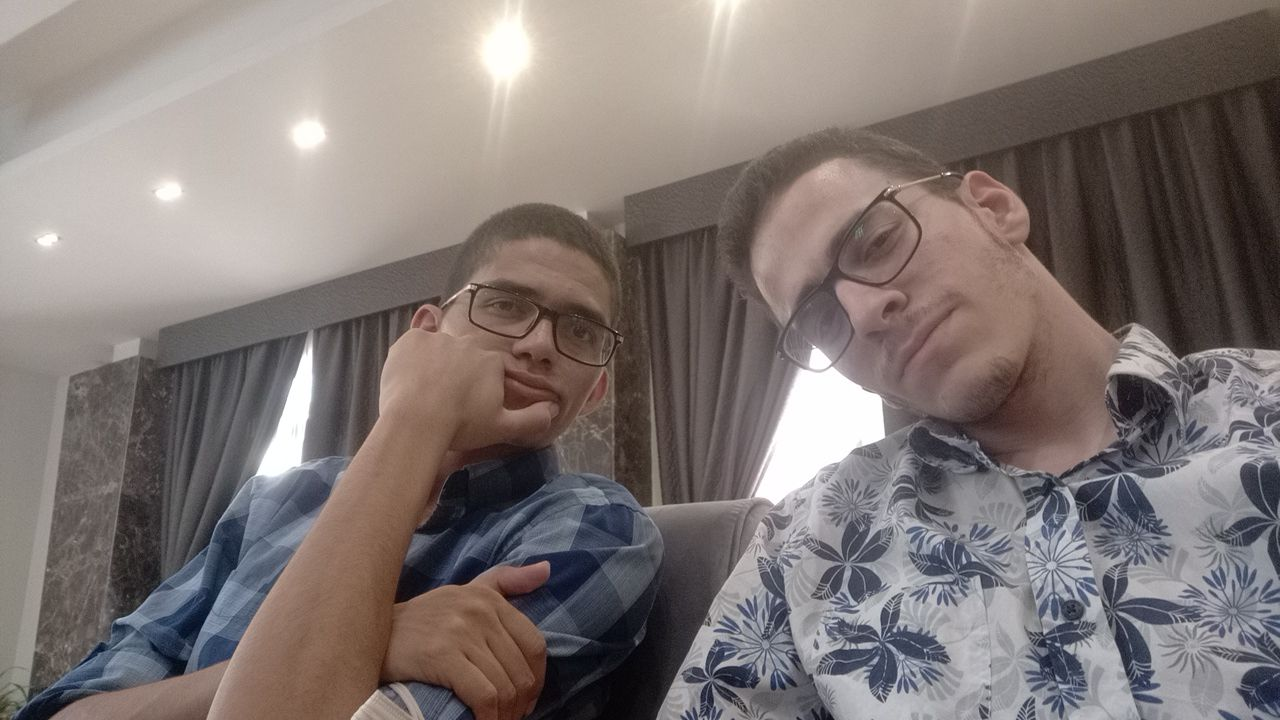

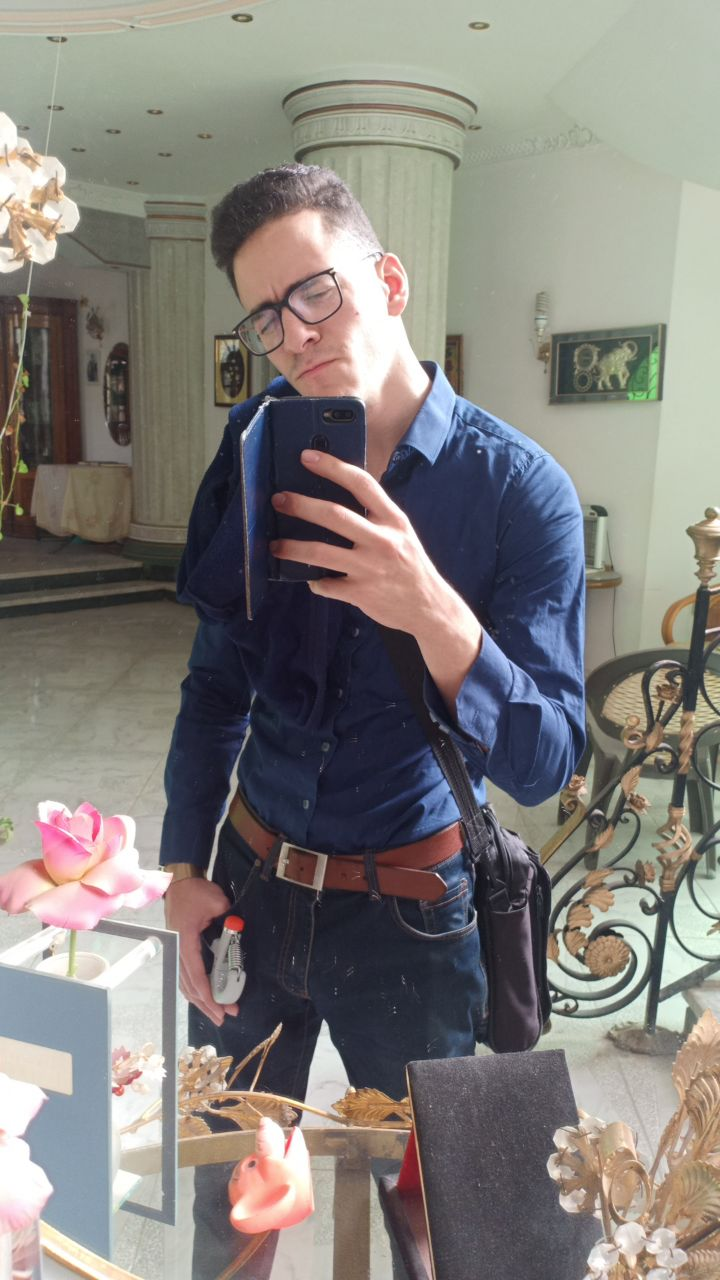

In [73]:
telegramNoExif = metaPhonePreviewDf[(metaPhonePreviewDf['EXIF_MAIN'].isna()) & (metaPhonePreviewDf['description'] == 'telegram')]
imgs = []
for fileName in telegramNoExif['imgName']:
    imgs.append(IPython.display.Image(filename=joinPaths('dataset_phone_preview', fileName), width=100))
display(*imgs)

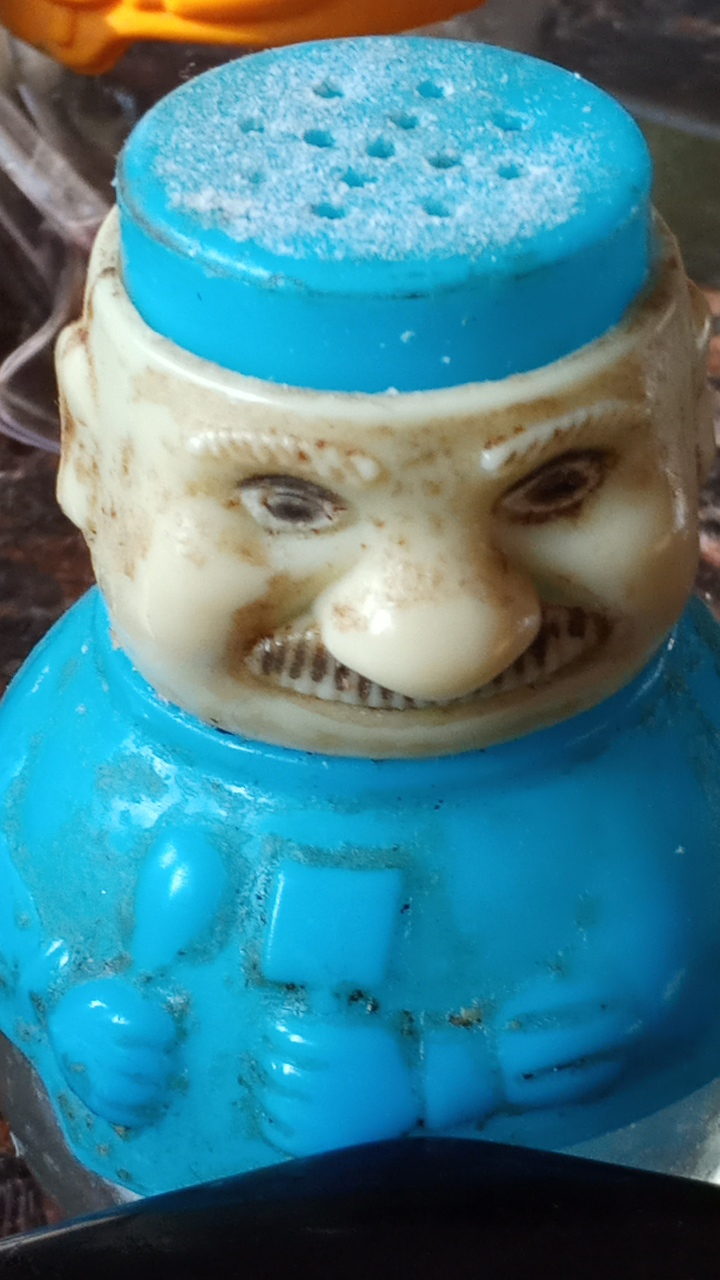

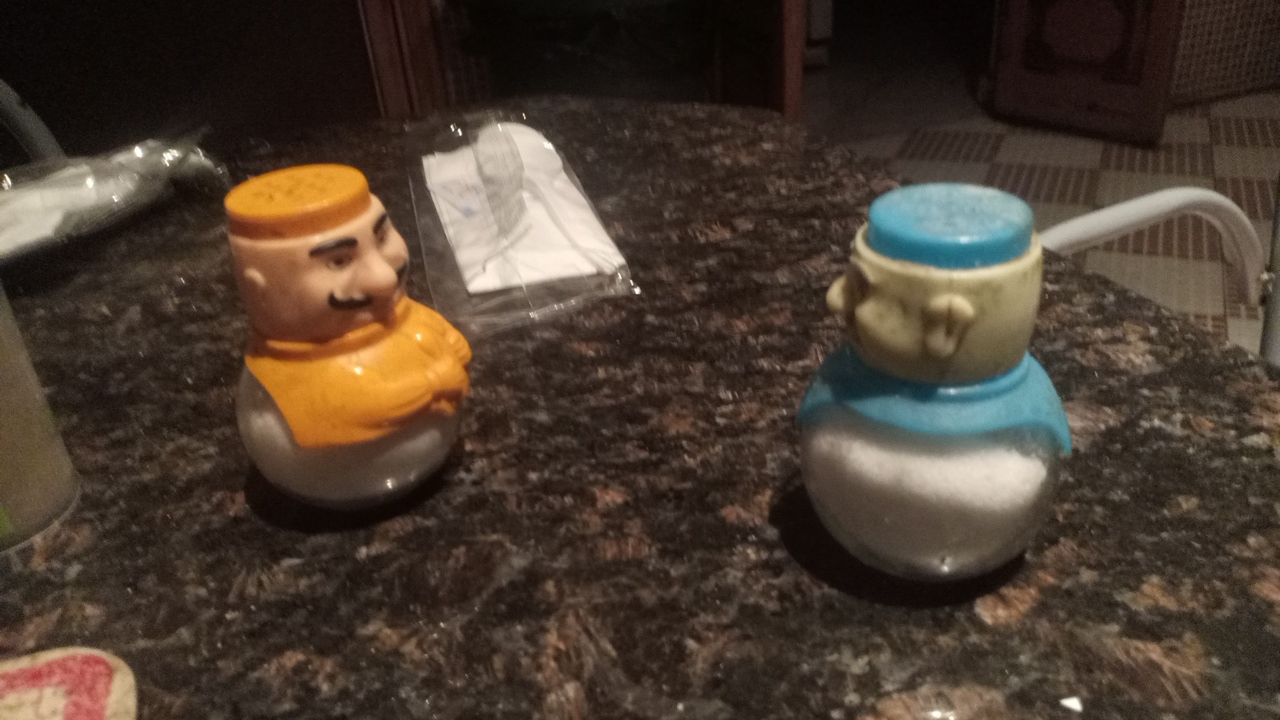

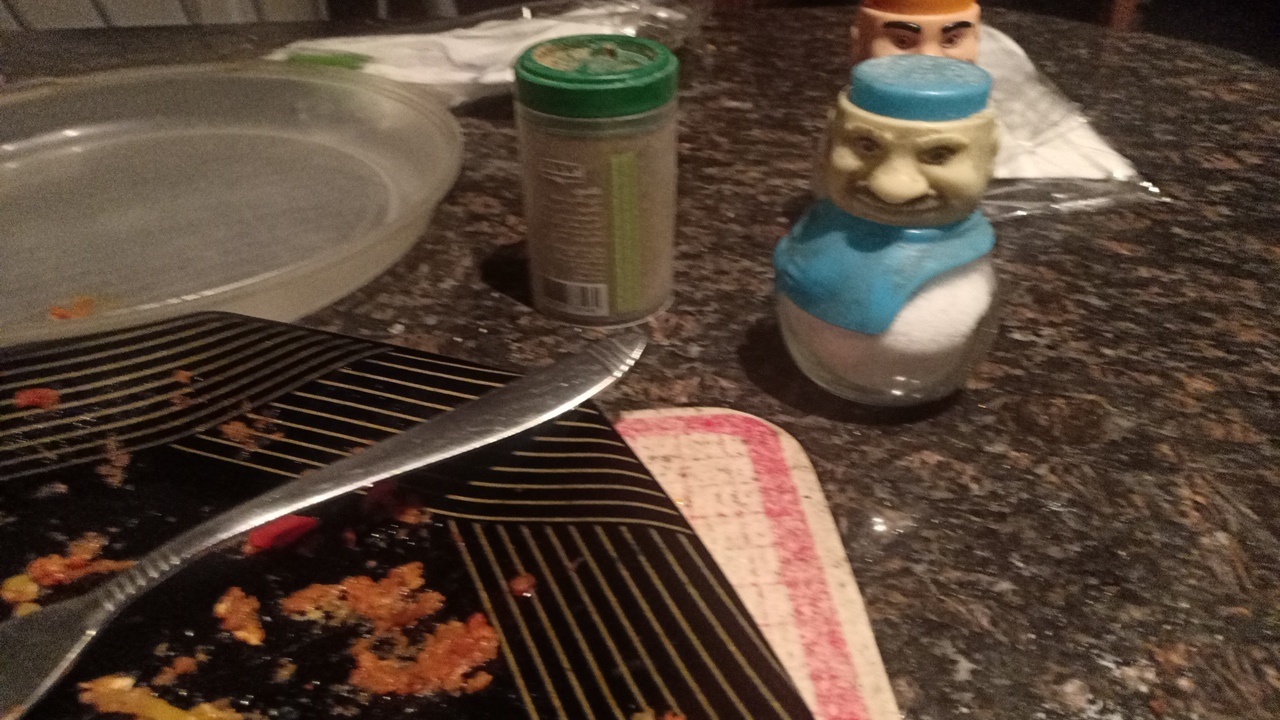

In [75]:
telegramExif = metaPhonePreviewDf[(~metaPhonePreviewDf['EXIF_MAIN'].isna()) & (metaPhonePreviewDf['description'] == 'telegram')]
imgs = []
for fileName in telegramExif['imgName']:
    imgs.append(IPython.display.Image(filename=joinPaths('dataset_phone_preview', fileName), width=100))
display(*imgs)

In [58]:
px.scatter(metaPhonePreviewDf, x='width', y='height', color='description', color_discrete_map={'internal storage':'red', 'whatsapp':'green', 'sd card':'red', 'telegram':'blue', 'screenshot':'pink'})